In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision.transforms import Resize
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')

# Constants for converting lat/lon to meters (approximate)
METERS_PER_DEG_LAT = 111_000  # ~111 km per degree latitude
METERS_PER_DEG_LON = 86_500   # ~86.5 km per degree longitude (varies with latitude)

def euclidean_distance_meters(pred_lat, pred_lon, true_lat, true_lon):
    """Calculate approximate Euclidean distance in meters between coordinates."""
    dlat_m = (pred_lat - true_lat) * METERS_PER_DEG_LAT
    dlon_m = (pred_lon - true_lon) * METERS_PER_DEG_LON
    return torch.sqrt(dlat_m**2 + dlon_m**2)

In [ ]:
class GlobalStreetscapesRegression(Dataset):
    def __init__(self, dataset, lat_mean, lat_std, lon_mean, lon_std):
        self.img_labels = dataset
        self.resize = Resize(size=(224, 224))
        # Store normalization parameters
        self.lat_mean = lat_mean
        self.lat_std = lat_std
        self.lon_mean = lon_mean
        self.lon_std = lon_std

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join("../", self.img_labels.iloc[idx].loc["path"])
        image = decode_image(img_path, apply_exif_orientation=True)
        image = self.resize(image)
        
        # Get coordinates and normalize them
        lat = self.img_labels.iloc[idx].loc["lat"]
        lon = self.img_labels.iloc[idx].loc["lon"]
        
        # Normalize coordinates (important for regression stability)
        lat_norm = (lat - self.lat_mean) / self.lat_std
        lon_norm = (lon - self.lon_mean) / self.lon_std
        
        coords = torch.tensor([lat_norm, lon_norm], dtype=torch.float32)
        return image, coords

In [ ]:
samples = pd.read_csv('../../data/imgs/sampled.csv', index_col=0)
paths = pd.read_csv('../../data/img_paths.csv', index_col=0)
img_labels = samples.join(paths, on='uuid', how='inner')

print("samples rows:", samples.shape[0])
print("paths rows:", paths.shape[0])
print("img_labels rows:", img_labels.shape[0])

# Calculate normalization parameters from full dataset BEFORE splitting
lat_mean = img_labels['lat'].mean()
lat_std = img_labels['lat'].std()
lon_mean = img_labels['lon'].mean()
lon_std = img_labels['lon'].std()

print(f"\nCoordinate statistics:")
print(f"Lat - Mean: {lat_mean:.6f}, Std: {lat_std:.6f}")
print(f"Lon - Mean: {lon_mean:.6f}, Std: {lon_std:.6f}")

# Store normalization params for later use
norm_params = {
    'lat_mean': lat_mean,
    'lat_std': lat_std,
    'lon_mean': lon_mean,
    'lon_std': lon_std
}

train_ratio = 0.8
train_df, test_df = train_test_split(img_labels, train_size=train_ratio, random_state=42)

display(train_df.head())

training_data = GlobalStreetscapesRegression(
    train_df, lat_mean, lat_std, lon_mean, lon_std
)

test_data = GlobalStreetscapesRegression(
    test_df, lat_mean, lat_std, lon_mean, lon_std
)

# Use num_workers for parallel data loading and pin_memory for faster GPU transfer
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True, num_workers=16, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True, num_workers=16, pin_memory=True)

samples rows: 190693
paths rows: 200656
img_labels rows: 190689


,uuid,source,orig_id,city,country,iso3,lat,lon,s2_cell_id,label,path
38166,4160834e-e98e-440e-86f8-ae3af625eac2,Mapillary,485531016014150,Washington,United States,USA,38.895089,-77.028196,9923602175718588416,16,../data/imgs/9f4de4aa-8e48-4dbe-86c8-48bb64cd9...
170459,e9e10532-2ad5-47b0-a1fa-f1698c59244e,Mapillary,762078037789303,Washington,United States,USA,38.900050,-77.035281,9923602329800540160,137,../data/imgs/58fe08ed-d183-41a6-925c-5dde1a371...
160298,abb12e35-414a-4365-8fb7-d95ea53fc96f,Mapillary,1957420271072024,Washington,United States,USA,38.902904,-77.022047,9923602144043204608,107,../data/imgs/844fdb33-33c9-4a73-ae36-db2ca2d5b...
121091,0cf9c4cb-9d83-40eb-b924-4634b25156af,Mapillary,228332565958468,Washington,United States,USA,38.907593,-77.025981,9923602531395567616,41,../data/imgs/6cdb6aa4-d2bc-4d53-a165-9fd9ddda8...
7557,97373a87-2609-42d2-8ccc-47172a57e1c6,Mapillary,617008059949954,Washington,United States,USA,38.903910,-77.027093,9923602147801300992,68,../data/imgs/35fa9773-14ea-4fed-90ec-20cff92ae...


Washington


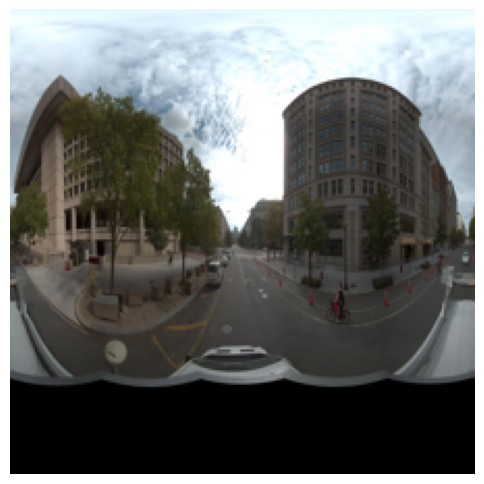

In [ ]:
p = os.path.join("../", training_data.img_labels.iloc[10].loc["path"])
lat = training_data.img_labels.iloc[10].loc["lat"]
lon = training_data.img_labels.iloc[10].loc["lon"]
print(f"City: {training_data.img_labels.iloc[10].loc['city']}")
print(f"Coordinates: ({lat:.6f}, {lon:.6f})")

img = Image.open(p).convert("RGB")
img = img.resize((224, 224))
plt.figure(figsize=(6, 10))
plt.imshow(img)
plt.title(f"Lat: {lat:.6f}, Lon: {lon:.6f}")
plt.axis("off")
plt.show()

In [ ]:
# Base Vision Transformer Docs: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py
# VIT_B_16 Docs: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html
weights = ViT_B_16_Weights.IMAGENET1K_V1
transform = weights.transforms()

model = vit_b_16(weights=weights)

in_features = model.heads.head.in_features

# Replace the classification head with a regression head (2 outputs: lat, lon)
print(f"Previous head: {model.heads.head}")
model.heads.head = nn.Sequential(
    nn.Linear(in_features=in_features, out_features=256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(in_features=256, out_features=2)  # 2 outputs: lat, lon
)
print(f"New head: {model.heads.head}")

model = model.to(device=device)
model = torch.compile(model)
print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:03<00:00, 93.1MB/s] 


Previous head: Linear(in_features=768, out_features=1000, bias=True)
Previous head: Linear(in_features=768, out_features=144, bias=True)
Number of classes: 144
Using device: cuda


In [ ]:
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
criterion = nn.MSELoss()  # MSE loss for regression

# Keep OneCycleLR with 10% warmup (same as original)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_dataloader),
    epochs=num_epochs,
    pct_start=0.1  # 10% of total steps used for warmup
)

# Track metrics
train_losses = []
val_losses = []
val_distances = []

for epoch in range(num_epochs):
    print(f"EPOCH: {epoch+1}")

    # Training phase
    current_loss = 0
    model.train()
    for inputs, coords in tqdm(train_dataloader):
        # Move to GPU with non_blocking for better performance
        inputs = inputs.to(device, non_blocking=True)
        coords = coords.to(device, non_blocking=True)
        
        inputs = transform(inputs)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, coords)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Moved inside the batch loop for OneCycleLR
        
        current_loss += loss.item()
    
    avg_train_loss = current_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Train MSE Loss: {avg_train_loss:.6f}")
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Validation phase
    model.eval()
    val_loss = 0
    total_distance = 0
    num_samples = 0
    
    with torch.no_grad():
        for inputs, coords in tqdm(test_dataloader, desc="Validating", leave=False):
            inputs = inputs.to(device, non_blocking=True)
            coords = coords.to(device, non_blocking=True)
            
            inputs = transform(inputs)
            outputs = model(inputs)
            
            loss = criterion(outputs, coords)
            val_loss += loss.item()
            
            # Denormalize for distance calculation
            pred_lat = outputs[:, 0] * norm_params['lat_std'] + norm_params['lat_mean']
            pred_lon = outputs[:, 1] * norm_params['lon_std'] + norm_params['lon_mean']
            true_lat = coords[:, 0] * norm_params['lat_std'] + norm_params['lat_mean']
            true_lon = coords[:, 1] * norm_params['lon_std'] + norm_params['lon_mean']
            
            distances = euclidean_distance_meters(pred_lat, pred_lon, true_lat, true_lon)
            total_distance += distances.sum().item()
            num_samples += coords.size(0)
    
    avg_val_loss = val_loss / len(test_dataloader)
    avg_distance = total_distance / num_samples
    val_losses.append(avg_val_loss)
    val_distances.append(avg_distance)
    
    print(f"Val MSE Loss: {avg_val_loss:.6f}")
    print(f"Val Mean Distance Error: {avg_distance:.2f} meters")
    
    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'val_distance': avg_distance,
        'norm_params': norm_params,
    }, f'vit_b_16_regression_epoch{epoch}.pth')

EPOCH: 1


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 4.141 (4.141)
LR: 0.000052
EPOCH: 2


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 2.359 (3.250)
LR: 0.000100
EPOCH: 3


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 1.760 (2.753)
LR: 0.000099
EPOCH: 4


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 1.446 (2.426)
LR: 0.000097
EPOCH: 5


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 1.238 (2.189)
LR: 0.000093
EPOCH: 6


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 1.083 (2.004)
LR: 0.000088
EPOCH: 7


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.977 (1.858)
LR: 0.000082
EPOCH: 8


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.913 (1.740)
LR: 0.000075
EPOCH: 9


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.878 (1.644)
LR: 0.000067
EPOCH: 10


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.858 (1.565)
LR: 0.000059
EPOCH: 11


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.853 (1.500)
LR: 0.000050
EPOCH: 12


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.844 (1.446)
LR: 0.000041
EPOCH: 13


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.837 (1.399)
LR: 0.000033
EPOCH: 14


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.828 (1.358)
LR: 0.000025
EPOCH: 15


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.824 (1.322)
LR: 0.000018
EPOCH: 16


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.822 (1.291)
LR: 0.000012
EPOCH: 17


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.821 (1.264)
LR: 0.000007
EPOCH: 18


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.821 (1.239)
LR: 0.000003
EPOCH: 19


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.821 (1.217)
LR: 0.000001
EPOCH: 20


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.821 (1.197)
LR: 0.000000


In [ ]:
# Final Evaluation
model.eval()
all_distances = []
all_predictions = []
all_targets = []
all_losses = []

with torch.no_grad():
    for inputs, coords in tqdm(test_dataloader, desc="Final Evaluation"):
        inputs = inputs.to(device, non_blocking=True)
        coords = coords.to(device, non_blocking=True)

        inputs = transform(inputs)
        outputs = model(inputs)
        
        # Calculate per-sample MSE loss (on normalized coords)
        sample_losses = ((outputs - coords) ** 2).mean(dim=1)
        all_losses.extend(sample_losses.cpu().numpy())
        
        # Denormalize predictions and targets
        pred_lat = outputs[:, 0] * norm_params['lat_std'] + norm_params['lat_mean']
        pred_lon = outputs[:, 1] * norm_params['lon_std'] + norm_params['lon_mean']
        true_lat = coords[:, 0] * norm_params['lat_std'] + norm_params['lat_mean']
        true_lon = coords[:, 1] * norm_params['lon_std'] + norm_params['lon_mean']
        
        distances = euclidean_distance_meters(pred_lat, pred_lon, true_lat, true_lon)
        all_distances.extend(distances.cpu().numpy())
        
        # Store for visualization
        all_predictions.extend(torch.stack([pred_lat, pred_lon], dim=1).cpu().numpy())
        all_targets.extend(torch.stack([true_lat, true_lon], dim=1).cpu().numpy())

all_distances = np.array(all_distances)
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
all_losses = np.array(all_losses)

# Calculate distance metrics
mean_distance = np.mean(all_distances)
median_distance = np.median(all_distances)
std_distance = np.std(all_distances)
percentile_25_dist = np.percentile(all_distances, 25)
percentile_75_dist = np.percentile(all_distances, 75)
percentile_90_dist = np.percentile(all_distances, 90)

# Calculate loss metrics
mean_loss = np.mean(all_losses)
median_loss = np.median(all_losses)

print("=" * 60)
print("FINAL TEST RESULTS")
print("=" * 60)
print("\n--- Distance Error Metrics ---")
print(f"Mean Distance Error: {mean_distance:.2f} meters")
print(f"Median Distance Error: {median_distance:.2f} meters")
print(f"Std Distance Error: {std_distance:.2f} meters")
print(f"25th Percentile: {percentile_25_dist:.2f} meters")
print(f"75th Percentile: {percentile_75_dist:.2f} meters")
print(f"90th Percentile: {percentile_90_dist:.2f} meters")
print(f"Min Distance Error: {np.min(all_distances):.2f} meters")
print(f"Max Distance Error: {np.max(all_distances):.2f} meters")

print("\n--- MSE Loss Metrics ---")
print(f"Mean MSE Loss: {mean_loss:.6f}")
print(f"Median MSE Loss: {median_loss:.6f}")

  0%|          | 0/149 [00:00<?, ?it/s]

Test Loss: 0.961
Test Accuracy: 96.29%


Calculating validation loss for saved checkpoints...


Epoch 1 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 1 Validation Loss: 2.839


Epoch 2 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 1.909


Epoch 3 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 1.563


Epoch 4 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 1.364


Epoch 5 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 1.219


Epoch 6 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 6 Validation Loss: 1.116


Epoch 7 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 7 Validation Loss: 1.060


Epoch 8 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 8 Validation Loss: 1.031


Epoch 9 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 9 Validation Loss: 1.005


Epoch 10 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 10 Validation Loss: 0.986


Epoch 11 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 11 Validation Loss: 0.993


Epoch 12 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 12 Validation Loss: 0.988


Epoch 13 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 13 Validation Loss: 0.967


Epoch 14 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 14 Validation Loss: 0.959


Epoch 15 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 15 Validation Loss: 0.958


Epoch 16 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 16 Validation Loss: 0.959


Epoch 17 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 17 Validation Loss: 0.960


Epoch 18 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 18 Validation Loss: 0.960


Epoch 19 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 19 Validation Loss: 0.961


Epoch 20 Val:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 20 Validation Loss: 0.961


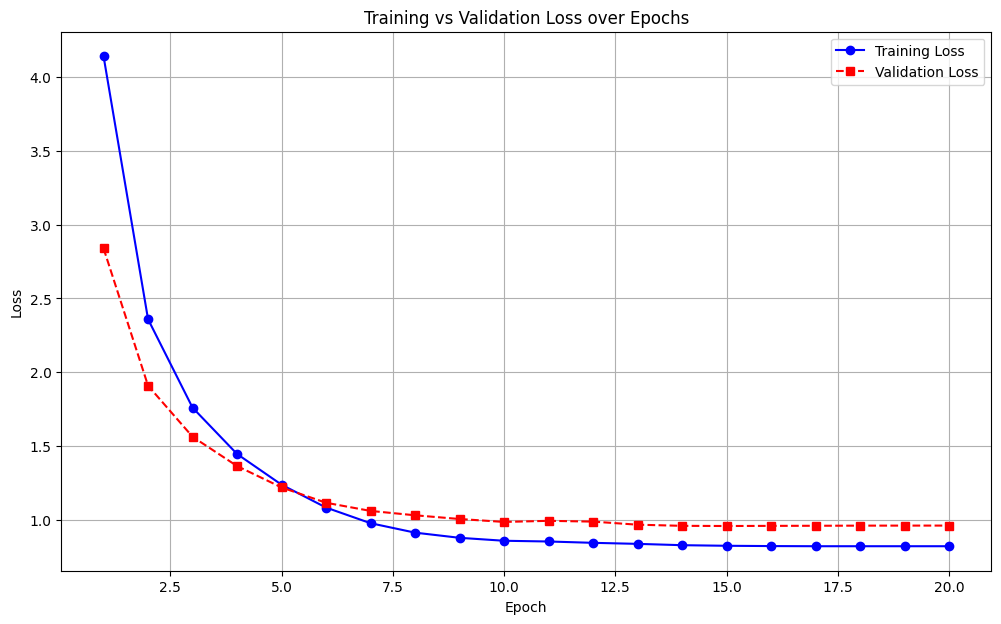

In [ ]:
# Visualization of Training Results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

epochs_range = range(1, len(train_losses) + 1)

# Plot 1: Training Loss Curve
ax1 = axes[0, 0]
ax1.plot(epochs_range, train_losses, 'b-o', label='Training MSE Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('MSE Loss', fontsize=12)
ax1.set_title('Training Loss over Epochs', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Training vs Validation Loss
ax2 = axes[0, 1]
ax2.plot(epochs_range, train_losses, 'b-o', label='Training MSE Loss', linewidth=2, markersize=6)
ax2.plot(epochs_range, val_losses, 'r-s', label='Validation MSE Loss', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MSE Loss', fontsize=12)
ax2.set_title('Training vs Validation Loss', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Validation Distance Error over Epochs
ax3 = axes[0, 2]
ax3.plot(epochs_range, val_distances, 'g-o', label='Validation Distance Error', linewidth=2, markersize=6)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Mean Distance Error (meters)', fontsize=12)
ax3.set_title('Validation Distance Error over Epochs', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Histogram of Distance Errors
ax4 = axes[1, 0]
ax4.hist(all_distances, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax4.axvline(mean_distance, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_distance:.1f}m')
ax4.axvline(median_distance, color='g', linestyle='--', linewidth=2, label=f'Median: {median_distance:.1f}m')
ax4.set_xlabel('Distance Error (meters)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Distribution of Distance Errors', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Histogram of MSE Losses
ax5 = axes[1, 1]
ax5.hist(all_losses, bins=50, edgecolor='black', alpha=0.7, color='orange')
ax5.axvline(mean_loss, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_loss:.4f}')
ax5.axvline(median_loss, color='g', linestyle='--', linewidth=2, label=f'Median: {median_loss:.4f}')
ax5.set_xlabel('MSE Loss', fontsize=12)
ax5.set_ylabel('Frequency', fontsize=12)
ax5.set_title('Distribution of MSE Losses', fontsize=14)
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Predicted vs Actual Locations (Scatter Plot)
ax6 = axes[1, 2]
sample_size = min(1000, len(all_predictions))
idx = np.random.choice(len(all_predictions), sample_size, replace=False)

ax6.scatter(all_targets[idx, 1], all_targets[idx, 0], alpha=0.5, s=15, label='True', c='blue')
ax6.scatter(all_predictions[idx, 1], all_predictions[idx, 0], alpha=0.5, s=15, label='Predicted', c='red')
ax6.set_xlabel('Longitude', fontsize=12)
ax6.set_ylabel('Latitude', fontsize=12)
ax6.set_title(f'Predicted vs True Locations (n={sample_size})', fontsize=14)
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regression_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nResults saved to 'regression_results.png'")

In [ ]:
# Visualize some individual predictions
def show_prediction(model, dataset, idx, transform, norm_params, device):
    """Show an image with its true and predicted coordinates."""
    model.eval()
    
    image, coords_norm = dataset[idx]
    
    # Get prediction
    with torch.no_grad():
        image_batch = image.unsqueeze(0).to(device)
        image_batch = transform(image_batch)
        output = model(image_batch)
    
    # Denormalize
    pred_lat = output[0, 0].item() * norm_params['lat_std'] + norm_params['lat_mean']
    pred_lon = output[0, 1].item() * norm_params['lon_std'] + norm_params['lon_mean']
    true_lat = coords_norm[0].item() * norm_params['lat_std'] + norm_params['lat_mean']
    true_lon = coords_norm[1].item() * norm_params['lon_std'] + norm_params['lon_mean']
    
    # Calculate distance
    dlat_m = (pred_lat - true_lat) * METERS_PER_DEG_LAT
    dlon_m = (pred_lon - true_lon) * METERS_PER_DEG_LON
    dist = np.sqrt(dlat_m**2 + dlon_m**2)
    
    # Display
    img_path = os.path.join("../", dataset.img_labels.iloc[idx].loc["path"])
    img = Image.open(img_path).convert("RGB")
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"True: ({true_lat:.5f}, {true_lon:.5f})\n"
              f"Pred: ({pred_lat:.5f}, {pred_lon:.5f})\n"
              f"Error: {dist:.1f} meters", fontsize=12)
    plt.axis("off")
    plt.show()
    
    return dist

# Show 5 random predictions
print("Sample Predictions:")
print("=" * 50)
for i in range(5):
    idx = np.random.randint(0, len(test_data))
    dist = show_prediction(model, test_data, idx, transform, norm_params, device)
    print(f"Sample {i+1}: Distance error = {dist:.2f} meters\n")

Class Report:   0%|          | 0/149 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.983     0.930     0.956       187
           1      0.975     0.963     0.969        80
           2      0.967     0.967     0.967        60
           3      0.981     0.977     0.979       309
           4      0.963     0.963     0.963       535
           5      0.958     0.970     0.964       330
           6      0.968     0.974     0.971       462
           7      0.954     0.945     0.949       307
           8      0.956     0.963     0.959       269
           9      0.943     0.964     0.954       309
          10      0.957     0.949     0.953       234
          11      0.951     0.977     0.964       220
          12      0.961     0.968     0.965       281
          13      0.967     0.960     0.964       277
          14      0.971     0.980     0.975       343
          15      0.981     0.968     0.975       219
          16      0.948     0.963     0.955       245
          17      0.958    

In [ ]:
# Additional Analysis: Error by geographic region
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Error magnitude on a map (color-coded scatter)
ax1 = axes[0]
scatter = ax1.scatter(all_targets[:, 1], all_targets[:, 0], 
                       c=all_distances, cmap='RdYlGn_r', alpha=0.6, s=10,
                       vmin=0, vmax=np.percentile(all_distances, 95))
plt.colorbar(scatter, ax=ax1, label='Distance Error (meters)')
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax1.set_title('Prediction Error by Location', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Error vectors (showing direction of prediction errors)
ax2 = axes[1]
sample_size = min(500, len(all_predictions))
idx = np.random.choice(len(all_predictions), sample_size, replace=False)

# Draw arrows from true to predicted locations
for i in idx:
    ax2.annotate('', xy=(all_predictions[i, 1], all_predictions[i, 0]),
                 xytext=(all_targets[i, 1], all_targets[i, 0]),
                 arrowprops=dict(arrowstyle='->', color='red', alpha=0.3, lw=0.5))

ax2.scatter(all_targets[idx, 1], all_targets[idx, 0], c='blue', s=10, alpha=0.5, label='True')
ax2.set_xlabel('Longitude', fontsize=12)
ax2.set_ylabel('Latitude', fontsize=12)
ax2.set_title(f'Prediction Error Vectors (n={sample_size})', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nError analysis saved to 'error_analysis.png'")